# Test data

In [1]:
import os
import librosa
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings

### Transcript

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
features_path = "/content/drive/MyDrive/speech_wav/features.csv"
df = pd.read_csv(features_path)
df.head()

,clipname,transcript,group,word,tone,indicator,type,sentence,word_count,mfcc_1,...,spect_4,spect_5,spect_6,spect_7,tonnetz_1,tonnetz_2,tonnetz_3,tonnetz_4,tonnetz_5,tonnetz_6
0,IWTGH_1,I want to go home.,1,Neutral,Neutral,NaN,Statement,Single,18,-456.161011,...,12.345949,13.214580,16.673017,31.776100,0.028255,-0.018589,0.115786,-0.013089,-0.031850,-0.050886
1,IWTGH_2,I want to go home.,1,Neutral,Anger,NaN,Statement,Single,18,-403.748169,...,12.661829,13.684149,17.276580,33.785295,0.000486,0.028319,0.064798,-0.031453,0.001535,-0.017270
2,IWTGH_3,I want to go home.,1,Neutral,Disgust,NaN,Statement,Single,18,-455.887939,...,12.708105,13.574046,15.457117,33.037995,0.022056,-0.044555,0.114726,-0.004732,-0.040863,-0.023962
3,IWTGH_4,I want to go home.,1,Neutral,Fear,NaN,Statement,Single,18,-460.136444,...,12.829127,13.194763,17.238967,32.216306,0.008253,-0.017944,0.081751,-0.002341,-0.019149,-0.016467
4,IWTGH_5,I want to go home.,1,Neutral,Sad,NaN,Statement,Single,18,-432.942596,...,12.880225,13.129890,17.900985,31.293743,0.010412,-0.034611,0.111465,-0.056060,-0.061425,-0.031940


### Audio

In [7]:
import librosa
import torchaudio

# Set audio directory
audio_dir = "/content/drive/MyDrive/speech_wav/audio"

# Load all audio files recursively
def load_audio_files(audio_dir):
    file_paths = {}
    total_files = 0

    for root, dirs, files in os.walk(audio_dir):
        for fname in files:
            if fname.endswith('.wav'):
                clip_name = fname.replace('.wav', '')
                full_path = os.path.join(root, fname)
                try:
                    waveform, sample_rate = torchaudio.load(full_path)
                    file_paths[clip_name] = waveform
                    total_files += 1
                except Exception as e:
                    print(f"Error loading {full_path}: {e}")

    print(f"Loaded {total_files} audio files across subfolders.")
    return file_paths

In [10]:
# Load audio
audio_data = load_audio_files(audio_dir)

# Map audio to dataframe
df['audio_path'] = df['clipname'].apply(lambda x: os.path.join(audio_dir, x + '.wav'))
df['audio'] = df['clipname'].map(audio_data)
#df = df[df['audio'].apply(lambda x: isinstance(x, torch.Tensor) or (isinstance(x, list) and torch.is_tensor(x[0])))]

# Display data
df.head()

Loaded 180 audio files across subfolders.


,clipname,transcript,group,word,tone,indicator,type,sentence,word_count,mfcc_1,...,spect_6,spect_7,tonnetz_1,tonnetz_2,tonnetz_3,tonnetz_4,tonnetz_5,tonnetz_6,audio_path,audio
0,IWTGH_1,I want to go home.,1,Neutral,Neutral,NaN,Statement,Single,18,-456.161011,...,16.673017,31.776100,0.028255,-0.018589,0.115786,-0.013089,-0.031850,-0.050886,/content/drive/MyDrive/speech_wav/audio/IWTGH_...,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0..."
1,IWTGH_2,I want to go home.,1,Neutral,Anger,NaN,Statement,Single,18,-403.748169,...,17.276580,33.785295,0.000486,0.028319,0.064798,-0.031453,0.001535,-0.017270,/content/drive/MyDrive/speech_wav/audio/IWTGH_...,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0..."
2,IWTGH_3,I want to go home.,1,Neutral,Disgust,NaN,Statement,Single,18,-455.887939,...,15.457117,33.037995,0.022056,-0.044555,0.114726,-0.004732,-0.040863,-0.023962,/content/drive/MyDrive/speech_wav/audio/IWTGH_...,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0..."
3,IWTGH_4,I want to go home.,1,Neutral,Fear,NaN,Statement,Single,18,-460.136444,...,17.238967,32.216306,0.008253,-0.017944,0.081751,-0.002341,-0.019149,-0.016467,/content/drive/MyDrive/speech_wav/audio/IWTGH_...,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0..."
4,IWTGH_5,I want to go home.,1,Neutral,Sad,NaN,Statement,Single,18,-432.942596,...,17.900985,31.293743,0.010412,-0.034611,0.111465,-0.056060,-0.061425,-0.031940,/content/drive/MyDrive/speech_wav/audio/IWTGH_...,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0..."


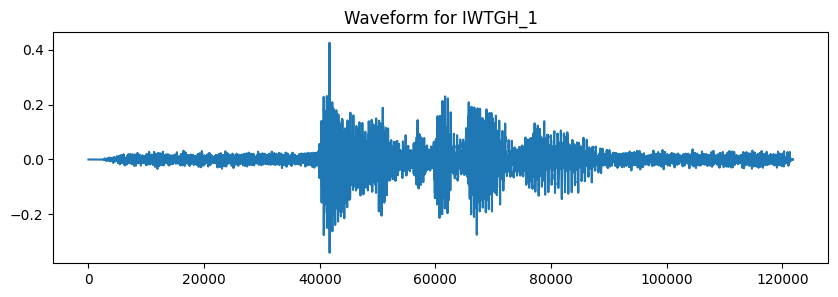

In [11]:
import matplotlib.pyplot as plt

waveform = df.iloc[0]['audio'][0]
plt.figure(figsize=(10, 3))
plt.plot(waveform.numpy())
plt.title(f"Waveform for {df.iloc[0]['clipname']}")
plt.show()

# Audio only

In [12]:
# HuggingFace Transformers modules
from transformers import (
    Wav2Vec2Model, Wav2Vec2FeatureExtractor,
    AutoTokenizer, AutoModelForSequenceClassification,
    AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
)

# Set seeds for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

In [13]:
class wav2Vec_transferModel(nn.Module):
    def __init__(self, pretrained_model_name="r-f/wav2vec-english-speech-emotion-recognition"):
        super().__init__()
        self.model = Wav2Vec2Model.from_pretrained(pretrained_model_name)
        for param in self.model.parameters():
            param.requires_grad = False
        self.dropout = nn.Dropout(0.2)

        # Match exactly what was saved
        self.classifier_emo = nn.Sequential(
            nn.Linear(self.model.config.hidden_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            self.dropout,
            nn.Linear(32, 6)
        )

    def forward(self, inputs):
        input_values = inputs['input_values']
        attention_mask = inputs['attention_mask']
        with torch.no_grad():
            outputs = self.model(input_values=input_values, attention_mask=attention_mask)
            pooled = outputs.last_hidden_state.mean(1)
        logits = self.classifier_emo(pooled)
        return logits

# Combined audio and text

In [14]:
class emotionDetectionSystem():
    def __init__(self, useAudio=True, useText=True):
        self.useAudio = useAudio
        self.useText = useText
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        # Load Wav2Vec2 model for audio emotion recognition
        if self.useAudio:
            self.wav2vec_modelName = "r-f/wav2vec-english-speech-emotion-recognition"
            self.wav2vec_model = wav2Vec_transferModel()
            self.wav2vec_model.load_state_dict(torch.load("bestWav2Vec.pth", map_location=self.device), strict=False)
            self.wav2vec_model.eval()
            self.wav2vec_model.to(self.device)
            self.audio_feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(self.wav2vec_modelName)

        # Load BERT-based text emotion classifier and Whisper transcription model
        if self.useText:
            self.textClassifier_model_name = "michellejieli/emotion_text_classifier"
            self.tokenizer = AutoTokenizer.from_pretrained(self.textClassifier_model_name)
            self.textModel = AutoModelForSequenceClassification.from_pretrained(self.textClassifier_model_name)
            self.textModel.to(self.device)
            self.textModel.eval()

            self.transcriptModel_id = "openai/whisper-large-v3-turbo"
            self.torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

            self.transcriptModel = AutoModelForSpeechSeq2Seq.from_pretrained(
                self.transcriptModel_id,
                torch_dtype=self.torch_dtype,
                low_cpu_mem_usage=True,
                use_safetensors=True
            ).to(self.device)

            self.transcriptProcessor = AutoProcessor.from_pretrained(self.transcriptModel_id)

            self.transcriptPipe = pipeline(
                "automatic-speech-recognition",
                model=self.transcriptModel,
                tokenizer=self.transcriptProcessor.tokenizer,
                feature_extractor=self.transcriptProcessor.feature_extractor,
                torch_dtype=self.torch_dtype,
                device=0 if self.device == "cuda" else -1,
            )

    def predict(self, audio_path=None):
        # Load and preprocess audio to 16kHz
        audio, sr = librosa.load(audio_path, sr=16000)

        # Convert to torch tensor and fix shape
        audio_tensor = torch.tensor(audio)
        if audio_tensor.ndim == 1:
            audio_tensor = audio_tensor.unsqueeze(0)  # [time] → [1, time]
        elif audio_tensor.ndim > 2:
            audio_tensor = audio_tensor.squeeze()

        # Audio-based prediction
        if self.useAudio:
            audioInput = self.audio_feature_extractor(
                audio_tensor.squeeze().numpy(), sampling_rate=16000, return_tensors="pt"
            ).to(self.device)

            with torch.no_grad():
                audio_logits = self.wav2vec_model(audioInput)
                audio_probs = F.softmax(audio_logits, dim=1)[0]

        # Text-based prediction via Whisper
        if self.useText:
            transcript = self.transcriptPipe(audio_path)["text"]
            inputs = self.tokenizer(transcript, return_tensors="pt", padding=True, truncation=True).to(self.device)

            with torch.no_grad():
                text_logits = self.textModel(**inputs).logits
                text_probs_raw = F.softmax(text_logits, dim=1)[0]

                text_probs = torch.tensor([
                    text_probs_raw[4],                   # Neutral
                    text_probs_raw[0],                   # Anger
                    text_probs_raw[1],                   # Disgust
                    text_probs_raw[2] + text_probs_raw[6],  # Fear + Surprise
                    text_probs_raw[5],                   # Sadness
                    text_probs_raw[3],                   # Happiness
                ], device=self.device)

        # Combine or return available predictions
        if self.useAudio and self.useText:
            emo_probs = (audio_probs + text_probs) / 2
        elif self.useAudio:
            emo_probs = audio_probs
        elif self.useText:
            emo_probs = text_probs
        else:
            raise ValueError("At least one of useAudio or useText must be True.")

        emoList = ["Neutral", "Anger", "Disgust", "Fear", "Sadness", "Happiness"]
        emo_pred = emoList[torch.argmax(emo_probs).item()]

        print(f"\nPredicted Emotion: {emo_pred}")
        print("\nEmotion Probabilities:")
        for i, prob in enumerate(emo_probs):
            print(f"{emoList[i]}: {prob.item():.4f}")

        return emo_pred

## Architect

Intialize models

In [15]:
# Install gdown if not already installed
!pip install -q gdown

# Download the .pth file using its Google Drive file ID
!gdown --id 1srF631gt6CkvSG6tWADsHxe6mS7H5gxi --output bestWav2Vec.pth

# Initialize audio only models
model_audio_only = wav2Vec_transferModel().to('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize audio + text models
model_text_audio = emotionDetectionSystem()

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1srF631gt6CkvSG6tWADsHxe6mS7H5gxi
From (redirected): https://drive.google.com/uc?id=1srF631gt6CkvSG6tWADsHxe6mS7H5gxi&confirm=t&uuid=213120b5-9dbc-4562-8b95-c076740ccfbf
To: /content/bestWav2Vec.pth
100% 1.26G/1.26G [00:20<00:00, 61.2MB/s]


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/2.73k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/262 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/413 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.62G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.77k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.71M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

Device set to use cuda:0


Data loader

In [16]:
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer=None, audio_only=True):
        self.df = df
        self.tokenizer = tokenizer
        self.audio_only = audio_only

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        audio = row['audio'][0]
        label = row['tone']

        if self.audio_only:
            return audio, label
        else:
            text = row['transcript']
            tokens = self.tokenizer(text, return_tensors='pt', padding='max_length', truncation=True)
            return audio, tokens, label

Evaluate model

In [17]:
def evaluate_model(model, dataloader, audio_only=True, device='cuda'):
    model.eval()
    preds, labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            if audio_only:
                audio, label = batch
                audio = audio.to(device)
                outputs = model(audio)
            else:
                audio, tokens, label = batch
                audio = audio.to(device)
                tokens = {k: v.squeeze(1).to(device) for k, v in tokens.items()}
                outputs = model(audio, tokens)

            pred = torch.argmax(outputs, dim=1)
            preds.extend(pred.cpu().numpy())
            labels.extend(label.cpu().numpy())

    return preds, labels

Run group for testing

In [18]:
def run_group(model, df_group, name="Unnamed"):
    print(f"\n Running: {name}")
    predictions = []

    is_system_wrapper = hasattr(model, "predict")

    for idx, row in df_group.iterrows():
        audio_tensor = row["audio"]  # shape: [1, 16000]

        # Save to temp .wav file if needed by Whisper pipeline
        temp_path = f"temp_audio_{idx}.wav"
        torchaudio.save(temp_path, audio_tensor, 16000)

        if is_system_wrapper:
            # For emotionDetectionSystem (audio + text)
            emotion = model.predict(audio_path=temp_path)
        else:
            # For raw audio model like wav2Vec_transferModel
            feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("r-f/wav2vec-english-speech-emotion-recognition")
            device = "cuda" if torch.cuda.is_available() else "cpu"
            inputs = feature_extractor(audio_tensor.squeeze().numpy(), sampling_rate=16000, return_tensors="pt")
            inputs = {k: v.to(device) for k, v in inputs.items()}

            with torch.no_grad():
                logits = model(inputs)
                probs = torch.nn.functional.softmax(logits, dim=-1)
                pred_idx = torch.argmax(probs, dim=-1).item()
                emotion = ["Neutral", "Anger", "Disgust", "Fear", "Sadness", "Happiness"][pred_idx]

        predictions.append(emotion)

    df_group = df_group.copy()
    df_group["predicted_emotion"] = predictions
    return df_group

# Testing

Group 1: Same sentences, different tones

Group 2: Different sentences, same tones

Group 3: Different sentences, different tones

In [19]:
# split groups for testing
group1_df = df[df['group'] == 1]
group2_df = df[df['group'] == 2]
group3_df = df[df['group'] == 3]

### Audio only

In [20]:
# Audio only
group1_pred = run_group(model_audio_only, group1_df, name="Group 1 - Audio Only")
group2_pred = run_group(model_audio_only, group2_df, name="Group 2 - Audio Only")
group3_pred = run_group(model_audio_only, group3_df, name="Group 3 - Audio Only")


 Running: Group 1 - Audio Only

 Running: Group 2 - Audio Only

 Running: Group 3 - Audio Only



 Evaluation for Group 1 - Audio Only
Accuracy: 0.1525

Classification Report:
              precision    recall  f1-score   support

     Neutral       0.15      1.00      0.26         9
       Anger       0.00      0.00      0.00        10
     Disgust       0.00      0.00      0.00        10
        Fear       0.00      0.00      0.00        10
     Sadness       0.00      0.00      0.00         0
   Happiness       0.00      0.00      0.00         0

   micro avg       0.15      0.23      0.18        39
   macro avg       0.03      0.17      0.04        39
weighted avg       0.04      0.23      0.06        39



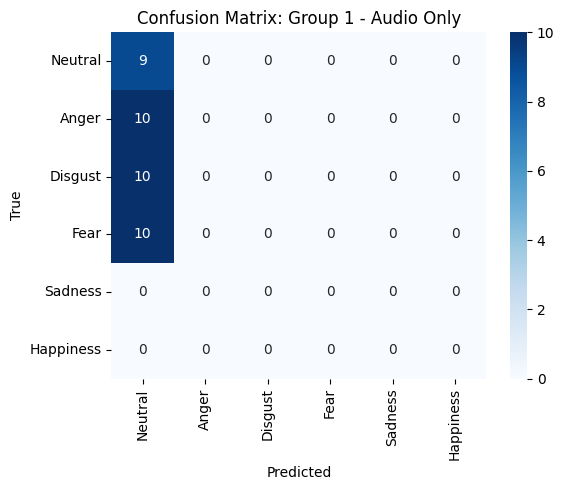


 Evaluation for Group 2 - Audio Only
Accuracy: 0.9667

Classification Report:
              precision    recall  f1-score   support

     Neutral       1.00      0.97      0.98        60
       Anger       0.00      0.00      0.00         0
     Disgust       0.00      0.00      0.00         0
        Fear       0.00      0.00      0.00         0
     Sadness       0.00      0.00      0.00         0
   Happiness       0.00      0.00      0.00         0

    accuracy                           0.97        60
   macro avg       0.17      0.16      0.16        60
weighted avg       1.00      0.97      0.98        60



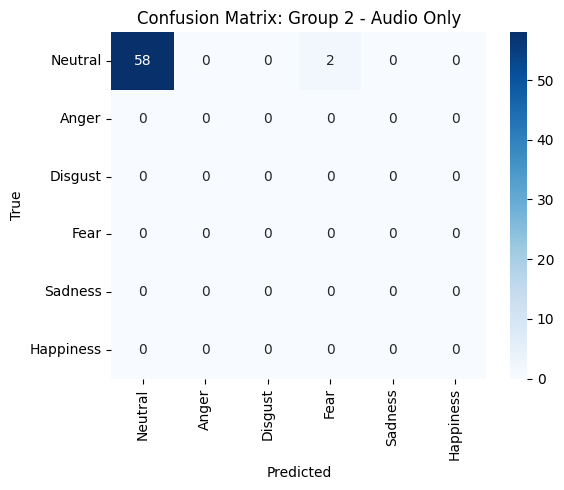


 Evaluation for Group 3 - Audio Only
Accuracy: 0.1833

Classification Report:
              precision    recall  f1-score   support

     Neutral       0.18      1.00      0.31        10
       Anger       0.00      0.00      0.00        10
     Disgust       0.00      0.00      0.00        10
        Fear       0.20      0.10      0.13        10
     Sadness       0.00      0.00      0.00         0
   Happiness       0.00      0.00      0.00         0

   micro avg       0.18      0.28      0.22        40
   macro avg       0.06      0.18      0.07        40
weighted avg       0.10      0.28      0.11        40



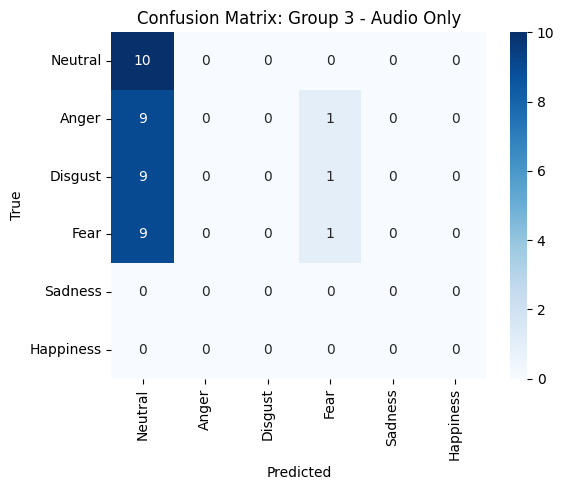

In [28]:
def evaluate_group(df, group_name, label_list=None):
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt

    print(f"\n Evaluation for {group_name}")
    y_true = df["tone"]
    y_pred = df["predicted_emotion"]

    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}")

    # Warn if any emotion labels are missing
    present_classes = set(y_true) | set(y_pred)
    missing = set(label_list) - present_classes
    if missing:
        print(f"Warning: These classes are missing in this group: {missing}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, labels=label_list, target_names=label_list, zero_division=0))

    cm = confusion_matrix(y_true, y_pred, labels=label_list)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_list, yticklabels=label_list, cmap='Blues')
    plt.title(f"Confusion Matrix: {group_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show(block=False)

emo_labels = ["Neutral", "Anger", "Disgust", "Fear", "Sadness", "Happiness"]

evaluate_group(group1_pred, "Group 1 - Audio Only", label_list=emo_labels)
evaluate_group(group2_pred, "Group 2 - Audio Only", label_list=emo_labels)
evaluate_group(group3_pred, "Group 3 - Audio Only", label_list=emo_labels)

### Audio + text

In [22]:
import torch.nn.functional as F

In [23]:
# Audio + Text
group1_pred_text = run_group(model_text_audio, group1_df, name="Group 1 - Audio + Text")
group2_pred_text = run_group(model_text_audio, group2_df, name="Group 2 - Audio + Text")
group3_pred_text = run_group(model_text_audio, group3_df, name="Group 3 - Audio + Text")


 Running: Group 1 - Audio + Text


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.7648
Anger: 0.0373
Disgust: 0.0528
Fear: 0.0648
Sadness: 0.0339
Happiness: 0.0463


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.7552
Anger: 0.0494
Disgust: 0.0524
Fear: 0.0615
Sadness: 0.0331
Happiness: 0.0484


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.7884
Anger: 0.0276
Disgust: 0.0524
Fear: 0.0586
Sadness: 0.0304
Happiness: 0.0425


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.6046
Anger: 0.0361
Disgust: 0.0529
Fear: 0.0649
Sadness: 0.1965
Happiness: 0.0450


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Happiness

Emotion Probabilities:
Neutral: 0.3110
Anger: 0.0449
Disgust: 0.0549
Fear: 0.0696
Sadness: 0.0345
Happiness: 0.4851


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.7011
Anger: 0.0524
Disgust: 0.0514
Fear: 0.0636
Sadness: 0.0322
Happiness: 0.0993


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.6164
Anger: 0.1606
Disgust: 0.0332
Fear: 0.0782
Sadness: 0.0377
Happiness: 0.0739


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.5138
Anger: 0.2493
Disgust: 0.0349
Fear: 0.0929
Sadness: 0.0399
Happiness: 0.0691


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Anger

Emotion Probabilities:
Neutral: 0.2532
Anger: 0.3393
Disgust: 0.0432
Fear: 0.2570
Sadness: 0.0377
Happiness: 0.0695


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.5808
Anger: 0.2000
Disgust: 0.0268
Fear: 0.0726
Sadness: 0.0519
Happiness: 0.0678


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.6551
Anger: 0.1149
Disgust: 0.0403
Fear: 0.0843
Sadness: 0.0397
Happiness: 0.0657


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.5577
Anger: 0.2464
Disgust: 0.0206
Fear: 0.0689
Sadness: 0.0341
Happiness: 0.0722


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.7021
Anger: 0.0792
Disgust: 0.0479
Fear: 0.0736
Sadness: 0.0414
Happiness: 0.0560


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Happiness

Emotion Probabilities:
Neutral: 0.2479
Anger: 0.0694
Disgust: 0.0500
Fear: 0.0739
Sadness: 0.0386
Happiness: 0.5203


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.5882
Anger: 0.0511
Disgust: 0.0548
Fear: 0.1880
Sadness: 0.0668
Happiness: 0.0511


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.7152
Anger: 0.0712
Disgust: 0.0474
Fear: 0.0745
Sadness: 0.0393
Happiness: 0.0524


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.4899
Anger: 0.0937
Disgust: 0.0816
Fear: 0.1773
Sadness: 0.1045
Happiness: 0.0530


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.5743
Anger: 0.2226
Disgust: 0.0241
Fear: 0.0701
Sadness: 0.0352
Happiness: 0.0737


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.5770
Anger: 0.2231
Disgust: 0.0239
Fear: 0.0708
Sadness: 0.0364
Happiness: 0.0688


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.5976
Anger: 0.2094
Disgust: 0.0251
Fear: 0.0669
Sadness: 0.0364
Happiness: 0.0646


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.5289
Anger: 0.1832
Disgust: 0.0575
Fear: 0.0744
Sadness: 0.0910
Happiness: 0.0650


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.5878
Anger: 0.2151
Disgust: 0.0262
Fear: 0.0674
Sadness: 0.0378
Happiness: 0.0657


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Anger

Emotion Probabilities:
Neutral: 0.1616
Anger: 0.4297
Disgust: 0.1647
Fear: 0.0727
Sadness: 0.0987
Happiness: 0.0726


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Disgust

Emotion Probabilities:
Neutral: 0.1195
Anger: 0.2298
Disgust: 0.3220
Fear: 0.0701
Sadness: 0.1915
Happiness: 0.0671


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.5868
Anger: 0.2139
Disgust: 0.0225
Fear: 0.0708
Sadness: 0.0351
Happiness: 0.0708


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Anger

Emotion Probabilities:
Neutral: 0.0853
Anger: 0.7092
Disgust: 0.0251
Fear: 0.0751
Sadness: 0.0336
Happiness: 0.0716


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.5758
Anger: 0.2230
Disgust: 0.0219
Fear: 0.0716
Sadness: 0.0355
Happiness: 0.0722


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.5708
Anger: 0.2318
Disgust: 0.0210
Fear: 0.0691
Sadness: 0.0348
Happiness: 0.0725


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.5731
Anger: 0.2234
Disgust: 0.0215
Fear: 0.0739
Sadness: 0.0345
Happiness: 0.0737


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.5630
Anger: 0.2413
Disgust: 0.0207
Fear: 0.0705
Sadness: 0.0331
Happiness: 0.0714


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.5589
Anger: 0.2096
Disgust: 0.0397
Fear: 0.0716
Sadness: 0.0380
Happiness: 0.0823


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.6609
Anger: 0.1465
Disgust: 0.0329
Fear: 0.0671
Sadness: 0.0371
Happiness: 0.0555


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.4612
Anger: 0.1345
Disgust: 0.0394
Fear: 0.0707
Sadness: 0.2375
Happiness: 0.0567


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.3216
Anger: 0.1659
Disgust: 0.1063
Fear: 0.2521
Sadness: 0.0488
Happiness: 0.1054


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.6195
Anger: 0.1499
Disgust: 0.0356
Fear: 0.0767
Sadness: 0.0593
Happiness: 0.0589


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.2855
Anger: 0.2526
Disgust: 0.0423
Fear: 0.1648
Sadness: 0.0825
Happiness: 0.1722


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.6089
Anger: 0.1817
Disgust: 0.0284
Fear: 0.0734
Sadness: 0.0378
Happiness: 0.0698


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.6612
Anger: 0.1171
Disgust: 0.0414
Fear: 0.0794
Sadness: 0.0428
Happiness: 0.0581


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Happiness

Emotion Probabilities:
Neutral: 0.1482
Anger: 0.2187
Disgust: 0.0245
Fear: 0.0713
Sadness: 0.0368
Happiness: 0.5005


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.6194
Anger: 0.1241
Disgust: 0.0431
Fear: 0.0780
Sadness: 0.0437
Happiness: 0.0917


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.6134
Anger: 0.1770
Disgust: 0.0311
Fear: 0.0775
Sadness: 0.0405
Happiness: 0.0605


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Happiness

Emotion Probabilities:
Neutral: 0.1437
Anger: 0.2076
Disgust: 0.0246
Fear: 0.0717
Sadness: 0.0368
Happiness: 0.5157


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.5651
Anger: 0.1434
Disgust: 0.0299
Fear: 0.1638
Sadness: 0.0314
Happiness: 0.0663


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.4935
Anger: 0.2290
Disgust: 0.0188
Fear: 0.1616
Sadness: 0.0273
Happiness: 0.0698


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.5423
Anger: 0.1699
Disgust: 0.0252
Fear: 0.1638
Sadness: 0.0282
Happiness: 0.0705


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.5455
Anger: 0.1646
Disgust: 0.0281
Fear: 0.1622
Sadness: 0.0336
Happiness: 0.0660


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.5210
Anger: 0.1919
Disgust: 0.0259
Fear: 0.1620
Sadness: 0.0342
Happiness: 0.0651


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.4888
Anger: 0.2306
Disgust: 0.0190
Fear: 0.1624
Sadness: 0.0276
Happiness: 0.0716


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Fear

Emotion Probabilities:
Neutral: 0.1047
Anger: 0.2269
Disgust: 0.0225
Fear: 0.5388
Sadness: 0.0321
Happiness: 0.0749


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Fear

Emotion Probabilities:
Neutral: 0.0746
Anger: 0.2661
Disgust: 0.0219
Fear: 0.5398
Sadness: 0.0275
Happiness: 0.0701


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Fear

Emotion Probabilities:
Neutral: 0.2065
Anger: 0.1138
Disgust: 0.0375
Fear: 0.5432
Sadness: 0.0335
Happiness: 0.0656


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Fear

Emotion Probabilities:
Neutral: 0.1990
Anger: 0.1566
Disgust: 0.0308
Fear: 0.5051
Sadness: 0.0327
Happiness: 0.0758


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Fear

Emotion Probabilities:
Neutral: 0.1440
Anger: 0.1776
Disgust: 0.0279
Fear: 0.5417
Sadness: 0.0332
Happiness: 0.0756


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Fear

Emotion Probabilities:
Neutral: 0.0717
Anger: 0.2352
Disgust: 0.0243
Fear: 0.5575
Sadness: 0.0333
Happiness: 0.0779


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Happiness

Emotion Probabilities:
Neutral: 0.2241
Anger: 0.2232
Disgust: 0.0231
Fear: 0.0680
Sadness: 0.0354
Happiness: 0.4262


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.5226
Anger: 0.2452
Disgust: 0.0256
Fear: 0.0702
Sadness: 0.0575
Happiness: 0.0789


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.3523
Anger: 0.2767
Disgust: 0.0805
Fear: 0.0721
Sadness: 0.1450
Happiness: 0.0735


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.5830
Anger: 0.2073
Disgust: 0.0249
Fear: 0.0747
Sadness: 0.0376
Happiness: 0.0725


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.5747
Anger: 0.2222
Disgust: 0.0215
Fear: 0.0698
Sadness: 0.0409
Happiness: 0.0709

 Running: Group 2 - Audio + Text


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.7798
Anger: 0.0329
Disgust: 0.0529
Fear: 0.0609
Sadness: 0.0328
Happiness: 0.0406


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.4476
Anger: 0.0418
Disgust: 0.0506
Fear: 0.0603
Sadness: 0.0358
Happiness: 0.3639


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.7396
Anger: 0.0369
Disgust: 0.0514
Fear: 0.0617
Sadness: 0.0331
Happiness: 0.0772


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.7469
Anger: 0.0448
Disgust: 0.0487
Fear: 0.0615
Sadness: 0.0357
Happiness: 0.0624


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Happiness

Emotion Probabilities:
Neutral: 0.3002
Anger: 0.0380
Disgust: 0.0493
Fear: 0.0580
Sadness: 0.0308
Happiness: 0.5237


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.7575
Anger: 0.0512
Disgust: 0.0489
Fear: 0.0604
Sadness: 0.0315
Happiness: 0.0505


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Sadness

Emotion Probabilities:
Neutral: 0.1811
Anger: 0.1229
Disgust: 0.0413
Fear: 0.0825
Sadness: 0.5086
Happiness: 0.0636


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.4136
Anger: 0.1576
Disgust: 0.1402
Fear: 0.1208
Sadness: 0.0984
Happiness: 0.0694


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Anger

Emotion Probabilities:
Neutral: 0.1581
Anger: 0.3836
Disgust: 0.0313
Fear: 0.2024
Sadness: 0.0956
Happiness: 0.1289


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Happiness

Emotion Probabilities:
Neutral: 0.1786
Anger: 0.1421
Disgust: 0.0530
Fear: 0.0831
Sadness: 0.0406
Happiness: 0.5027


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.6690
Anger: 0.1089
Disgust: 0.0489
Fear: 0.0718
Sadness: 0.0380
Happiness: 0.0635


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.4018
Anger: 0.1567
Disgust: 0.1278
Fear: 0.1847
Sadness: 0.0587
Happiness: 0.0704


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Sadness

Emotion Probabilities:
Neutral: 0.2327
Anger: 0.0894
Disgust: 0.0663
Fear: 0.0719
Sadness: 0.4926
Happiness: 0.0470


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.6348
Anger: 0.1225
Disgust: 0.0508
Fear: 0.0743
Sadness: 0.0488
Happiness: 0.0687


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.6565
Anger: 0.1118
Disgust: 0.0485
Fear: 0.0825
Sadness: 0.0468
Happiness: 0.0539


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Sadness

Emotion Probabilities:
Neutral: 0.1828
Anger: 0.1402
Disgust: 0.0373
Fear: 0.0761
Sadness: 0.5015
Happiness: 0.0621


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.6013
Anger: 0.1779
Disgust: 0.0333
Fear: 0.0712
Sadness: 0.0402
Happiness: 0.0762


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.6195
Anger: 0.1533
Disgust: 0.0393
Fear: 0.0729
Sadness: 0.0402
Happiness: 0.0748


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.3559
Anger: 0.1600
Disgust: 0.1497
Fear: 0.0723
Sadness: 0.0442
Happiness: 0.2179


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.6247
Anger: 0.1762
Disgust: 0.0308
Fear: 0.0677
Sadness: 0.0403
Happiness: 0.0603


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Happiness

Emotion Probabilities:
Neutral: 0.2142
Anger: 0.2185
Disgust: 0.0321
Fear: 0.0947
Sadness: 0.1093
Happiness: 0.3312


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.5738
Anger: 0.1938
Disgust: 0.0362
Fear: 0.0709
Sadness: 0.0618
Happiness: 0.0635


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Sadness

Emotion Probabilities:
Neutral: 0.1408
Anger: 0.1691
Disgust: 0.0336
Fear: 0.0679
Sadness: 0.5318
Happiness: 0.0569


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.5956
Anger: 0.1872
Disgust: 0.0294
Fear: 0.0679
Sadness: 0.0394
Happiness: 0.0805


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Happiness

Emotion Probabilities:
Neutral: 0.1951
Anger: 0.2533
Disgust: 0.0333
Fear: 0.0677
Sadness: 0.0343
Happiness: 0.4163


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Sadness

Emotion Probabilities:
Neutral: 0.2653
Anger: 0.2430
Disgust: 0.0280
Fear: 0.0881
Sadness: 0.3047
Happiness: 0.0709


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.5896
Anger: 0.2090
Disgust: 0.0232
Fear: 0.0708
Sadness: 0.0360
Happiness: 0.0714


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.5507
Anger: 0.2192
Disgust: 0.0225
Fear: 0.0697
Sadness: 0.0383
Happiness: 0.0995


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.6229
Anger: 0.1639
Disgust: 0.0325
Fear: 0.0737
Sadness: 0.0394
Happiness: 0.0675


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.5021
Anger: 0.2499
Disgust: 0.0196
Fear: 0.0707
Sadness: 0.0334
Happiness: 0.1242


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.5774
Anger: 0.1212
Disgust: 0.0358
Fear: 0.0706
Sadness: 0.0406
Happiness: 0.1543


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.6720
Anger: 0.1234
Disgust: 0.0360
Fear: 0.0743
Sadness: 0.0386
Happiness: 0.0558


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.6114
Anger: 0.1787
Disgust: 0.0387
Fear: 0.0737
Sadness: 0.0396
Happiness: 0.0578


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.4867
Anger: 0.1565
Disgust: 0.0434
Fear: 0.0826
Sadness: 0.1731
Happiness: 0.0577


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.6419
Anger: 0.1448
Disgust: 0.0346
Fear: 0.0802
Sadness: 0.0415
Happiness: 0.0570


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Disgust

Emotion Probabilities:
Neutral: 0.2815
Anger: 0.1180
Disgust: 0.4018
Fear: 0.1006
Sadness: 0.0456
Happiness: 0.0525


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Happiness

Emotion Probabilities:
Neutral: 0.1816
Anger: 0.1848
Disgust: 0.0288
Fear: 0.0727
Sadness: 0.0407
Happiness: 0.4912


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.4116
Anger: 0.1814
Disgust: 0.1854
Fear: 0.0904
Sadness: 0.0766
Happiness: 0.0546


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.6321
Anger: 0.1608
Disgust: 0.0325
Fear: 0.0756
Sadness: 0.0425
Happiness: 0.0565


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.5726
Anger: 0.2211
Disgust: 0.0244
Fear: 0.0770
Sadness: 0.0405
Happiness: 0.0644


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.5292
Anger: 0.1922
Disgust: 0.0576
Fear: 0.0780
Sadness: 0.0853
Happiness: 0.0576


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.3886
Anger: 0.1886
Disgust: 0.0367
Fear: 0.0750
Sadness: 0.2518
Happiness: 0.0593


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Fear

Emotion Probabilities:
Neutral: 0.2050
Anger: 0.2368
Disgust: 0.0859
Fear: 0.3380
Sadness: 0.0627
Happiness: 0.0716


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.3279
Anger: 0.3183
Disgust: 0.0734
Fear: 0.1745
Sadness: 0.0347
Happiness: 0.0711


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Fear

Emotion Probabilities:
Neutral: 0.0976
Anger: 0.2211
Disgust: 0.0321
Fear: 0.5482
Sadness: 0.0294
Happiness: 0.0715


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.5773
Anger: 0.2195
Disgust: 0.0214
Fear: 0.0787
Sadness: 0.0314
Happiness: 0.0717


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.5115
Anger: 0.2277
Disgust: 0.0445
Fear: 0.0880
Sadness: 0.0564
Happiness: 0.0720


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.5170
Anger: 0.1959
Disgust: 0.0228
Fear: 0.1019
Sadness: 0.0299
Happiness: 0.1326


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Fear

Emotion Probabilities:
Neutral: 0.2236
Anger: 0.2232
Disgust: 0.0247
Fear: 0.4221
Sadness: 0.0352
Happiness: 0.0712


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Fear

Emotion Probabilities:
Neutral: 0.1261
Anger: 0.2343
Disgust: 0.0268
Fear: 0.5074
Sadness: 0.0335
Happiness: 0.0719


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Anger

Emotion Probabilities:
Neutral: 0.1111
Anger: 0.4048
Disgust: 0.0383
Fear: 0.3261
Sadness: 0.0481
Happiness: 0.0716


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Fear

Emotion Probabilities:
Neutral: 0.2603
Anger: 0.1693
Disgust: 0.0324
Fear: 0.4246
Sadness: 0.0447
Happiness: 0.0686


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Fear

Emotion Probabilities:
Neutral: 0.1511
Anger: 0.2134
Disgust: 0.1194
Fear: 0.2847
Sadness: 0.1611
Happiness: 0.0702


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Fear

Emotion Probabilities:
Neutral: 0.1963
Anger: 0.1367
Disgust: 0.0323
Fear: 0.5347
Sadness: 0.0340
Happiness: 0.0660


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.5511
Anger: 0.2389
Disgust: 0.0240
Fear: 0.0706
Sadness: 0.0368
Happiness: 0.0786


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Sadness

Emotion Probabilities:
Neutral: 0.2004
Anger: 0.2343
Disgust: 0.0259
Fear: 0.0701
Sadness: 0.3972
Happiness: 0.0721


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.5021
Anger: 0.2413
Disgust: 0.0383
Fear: 0.0687
Sadness: 0.0776
Happiness: 0.0721


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.5980
Anger: 0.1792
Disgust: 0.0435
Fear: 0.0764
Sadness: 0.0444
Happiness: 0.0585


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Happiness

Emotion Probabilities:
Neutral: 0.0963
Anger: 0.2221
Disgust: 0.0223
Fear: 0.0724
Sadness: 0.0386
Happiness: 0.5482


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.4855
Anger: 0.2020
Disgust: 0.0474
Fear: 0.0759
Sadness: 0.1184
Happiness: 0.0708

 Running: Group 3 - Audio + Text


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.6812
Anger: 0.0518
Disgust: 0.0576
Fear: 0.0603
Sadness: 0.0347
Happiness: 0.1145


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Happiness

Emotion Probabilities:
Neutral: 0.2636
Anger: 0.0622
Disgust: 0.0460
Fear: 0.0582
Sadness: 0.0314
Happiness: 0.5386


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.7401
Anger: 0.0585
Disgust: 0.0491
Fear: 0.0658
Sadness: 0.0355
Happiness: 0.0510


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.7269
Anger: 0.0689
Disgust: 0.0460
Fear: 0.0648
Sadness: 0.0414
Happiness: 0.0521


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Happiness

Emotion Probabilities:
Neutral: 0.2781
Anger: 0.0441
Disgust: 0.0487
Fear: 0.0624
Sadness: 0.0359
Happiness: 0.5307


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.7478
Anger: 0.0605
Disgust: 0.0480
Fear: 0.0617
Sadness: 0.0321
Happiness: 0.0499


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.6060
Anger: 0.1783
Disgust: 0.0312
Fear: 0.0835
Sadness: 0.0392
Happiness: 0.0618


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Disgust

Emotion Probabilities:
Neutral: 0.1819
Anger: 0.2133
Disgust: 0.4143
Fear: 0.0804
Sadness: 0.0427
Happiness: 0.0673


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.6169
Anger: 0.1683
Disgust: 0.0321
Fear: 0.0771
Sadness: 0.0401
Happiness: 0.0655


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.6017
Anger: 0.1959
Disgust: 0.0267
Fear: 0.0685
Sadness: 0.0376
Happiness: 0.0696


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Anger

Emotion Probabilities:
Neutral: 0.2893
Anger: 0.3544
Disgust: 0.1401
Fear: 0.0758
Sadness: 0.0838
Happiness: 0.0566


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.3266
Anger: 0.2169
Disgust: 0.0262
Fear: 0.0709
Sadness: 0.0800
Happiness: 0.2793


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Disgust

Emotion Probabilities:
Neutral: 0.1895
Anger: 0.2452
Disgust: 0.3840
Fear: 0.0767
Sadness: 0.0461
Happiness: 0.0585


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.5558
Anger: 0.2191
Disgust: 0.0527
Fear: 0.0670
Sadness: 0.0420
Happiness: 0.0635


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Happiness

Emotion Probabilities:
Neutral: 0.1317
Anger: 0.2029
Disgust: 0.0283
Fear: 0.2903
Sadness: 0.0371
Happiness: 0.3096


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.5375
Anger: 0.1980
Disgust: 0.0292
Fear: 0.1163
Sadness: 0.0381
Happiness: 0.0808


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.5064
Anger: 0.2183
Disgust: 0.0792
Fear: 0.0952
Sadness: 0.0390
Happiness: 0.0618


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.5902
Anger: 0.1999
Disgust: 0.0378
Fear: 0.0690
Sadness: 0.0383
Happiness: 0.0649


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.5978
Anger: 0.1826
Disgust: 0.0304
Fear: 0.0678
Sadness: 0.0406
Happiness: 0.0809


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.6155
Anger: 0.1757
Disgust: 0.0317
Fear: 0.0770
Sadness: 0.0392
Happiness: 0.0609


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Fear

Emotion Probabilities:
Neutral: 0.2764
Anger: 0.2156
Disgust: 0.0271
Fear: 0.3645
Sadness: 0.0535
Happiness: 0.0630


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.3781
Anger: 0.3107
Disgust: 0.1310
Fear: 0.0686
Sadness: 0.0429
Happiness: 0.0688


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Happiness

Emotion Probabilities:
Neutral: 0.1730
Anger: 0.1482
Disgust: 0.0352
Fear: 0.0675
Sadness: 0.0429
Happiness: 0.5332


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.6708
Anger: 0.1210
Disgust: 0.0380
Fear: 0.0650
Sadness: 0.0403
Happiness: 0.0650


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.5636
Anger: 0.2146
Disgust: 0.0241
Fear: 0.0734
Sadness: 0.0545
Happiness: 0.0698


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.4936
Anger: 0.2571
Disgust: 0.0493
Fear: 0.0648
Sadness: 0.0697
Happiness: 0.0656


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.6199
Anger: 0.1771
Disgust: 0.0287
Fear: 0.0736
Sadness: 0.0380
Happiness: 0.0628


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.5667
Anger: 0.2366
Disgust: 0.0216
Fear: 0.0647
Sadness: 0.0403
Happiness: 0.0701


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Happiness

Emotion Probabilities:
Neutral: 0.1731
Anger: 0.1648
Disgust: 0.0300
Fear: 0.0740
Sadness: 0.0405
Happiness: 0.5175


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Happiness

Emotion Probabilities:
Neutral: 0.3079
Anger: 0.2325
Disgust: 0.0229
Fear: 0.0677
Sadness: 0.0366
Happiness: 0.3324


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Sadness

Emotion Probabilities:
Neutral: 0.1844
Anger: 0.1406
Disgust: 0.0345
Fear: 0.0756
Sadness: 0.5088
Happiness: 0.0560


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.3835
Anger: 0.1436
Disgust: 0.0342
Fear: 0.0710
Sadness: 0.1780
Happiness: 0.1897


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Sadness

Emotion Probabilities:
Neutral: 0.1794
Anger: 0.1256
Disgust: 0.0373
Fear: 0.0694
Sadness: 0.5294
Happiness: 0.0588


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Sadness

Emotion Probabilities:
Neutral: 0.2189
Anger: 0.2575
Disgust: 0.0460
Fear: 0.0919
Sadness: 0.3240
Happiness: 0.0617


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.6411
Anger: 0.1499
Disgust: 0.0349
Fear: 0.0722
Sadness: 0.0407
Happiness: 0.0611


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Sadness

Emotion Probabilities:
Neutral: 0.1978
Anger: 0.1228
Disgust: 0.0348
Fear: 0.0754
Sadness: 0.5135
Happiness: 0.0557


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.5781
Anger: 0.2055
Disgust: 0.0268
Fear: 0.0698
Sadness: 0.0368
Happiness: 0.0830


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.3032
Anger: 0.2686
Disgust: 0.0496
Fear: 0.0901
Sadness: 0.2249
Happiness: 0.0635


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.6078
Anger: 0.1965
Disgust: 0.0288
Fear: 0.0681
Sadness: 0.0372
Happiness: 0.0617


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Fear

Emotion Probabilities:
Neutral: 0.1540
Anger: 0.2394
Disgust: 0.0453
Fear: 0.4604
Sadness: 0.0333
Happiness: 0.0677


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.3612
Anger: 0.2218
Disgust: 0.0335
Fear: 0.0849
Sadness: 0.2385
Happiness: 0.0601


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.6173
Anger: 0.1813
Disgust: 0.0307
Fear: 0.0706
Sadness: 0.0415
Happiness: 0.0586


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Fear

Emotion Probabilities:
Neutral: 0.1745
Anger: 0.2728
Disgust: 0.0823
Fear: 0.3363
Sadness: 0.0625
Happiness: 0.0716


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Anger

Emotion Probabilities:
Neutral: 0.3185
Anger: 0.3379
Disgust: 0.0705
Fear: 0.1724
Sadness: 0.0315
Happiness: 0.0693


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Fear

Emotion Probabilities:
Neutral: 0.0883
Anger: 0.2421
Disgust: 0.0265
Fear: 0.5458
Sadness: 0.0281
Happiness: 0.0692


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.6197
Anger: 0.1731
Disgust: 0.0263
Fear: 0.0799
Sadness: 0.0325
Happiness: 0.0685


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.5556
Anger: 0.1854
Disgust: 0.0295
Fear: 0.1213
Sadness: 0.0378
Happiness: 0.0704


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.4668
Anger: 0.2659
Disgust: 0.0162
Fear: 0.0945
Sadness: 0.0270
Happiness: 0.1297


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Fear

Emotion Probabilities:
Neutral: 0.1370
Anger: 0.2217
Disgust: 0.0683
Fear: 0.4690
Sadness: 0.0323
Happiness: 0.0718


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Anger

Emotion Probabilities:
Neutral: 0.0819
Anger: 0.4046
Disgust: 0.2210
Fear: 0.1960
Sadness: 0.0323
Happiness: 0.0642


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Anger

Emotion Probabilities:
Neutral: 0.0765
Anger: 0.4685
Disgust: 0.0321
Fear: 0.3137
Sadness: 0.0438
Happiness: 0.0655


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Fear

Emotion Probabilities:
Neutral: 0.1799
Anger: 0.2642
Disgust: 0.0214
Fear: 0.4187
Sadness: 0.0434
Happiness: 0.0724


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Anger

Emotion Probabilities:
Neutral: 0.0833
Anger: 0.3002
Disgust: 0.1090
Fear: 0.2761
Sadness: 0.1583
Happiness: 0.0731


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Fear

Emotion Probabilities:
Neutral: 0.0845
Anger: 0.2426
Disgust: 0.0204
Fear: 0.5514
Sadness: 0.0311
Happiness: 0.0700


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.4546
Anger: 0.2144
Disgust: 0.0919
Fear: 0.0733
Sadness: 0.0960
Happiness: 0.0697


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.5645
Anger: 0.2403
Disgust: 0.0228
Fear: 0.0670
Sadness: 0.0330
Happiness: 0.0724


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Happiness

Emotion Probabilities:
Neutral: 0.1599
Anger: 0.1871
Disgust: 0.0271
Fear: 0.0705
Sadness: 0.0416
Happiness: 0.5137


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Neutral

Emotion Probabilities:
Neutral: 0.5907
Anger: 0.1741
Disgust: 0.0397
Fear: 0.0755
Sadness: 0.0450
Happiness: 0.0749


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Anger

Emotion Probabilities:
Neutral: 0.1088
Anger: 0.3739
Disgust: 0.3362
Fear: 0.0730
Sadness: 0.0430
Happiness: 0.0652


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(



Predicted Emotion: Anger

Emotion Probabilities:
Neutral: 0.2364
Anger: 0.4132
Disgust: 0.1395
Fear: 0.0723
Sadness: 0.0688
Happiness: 0.0697



 Evaluation for Group 1 - Audio + Text
 Accuracy: 0.1695

 Classification Report:
              precision    recall  f1-score   support

       Anger       0.33      0.10      0.15        10
     Disgust       0.00      0.00      0.00        10
        Fear       0.17      0.10      0.12        10
   Happiness       0.00      0.00      0.00         0
       Happy       0.00      0.00      0.00        10
     Neutral       0.18      0.89      0.30         9
         Sad       0.00      0.00      0.00        10

    accuracy                           0.17        59
   macro avg       0.10      0.16      0.08        59
weighted avg       0.11      0.17      0.09        59



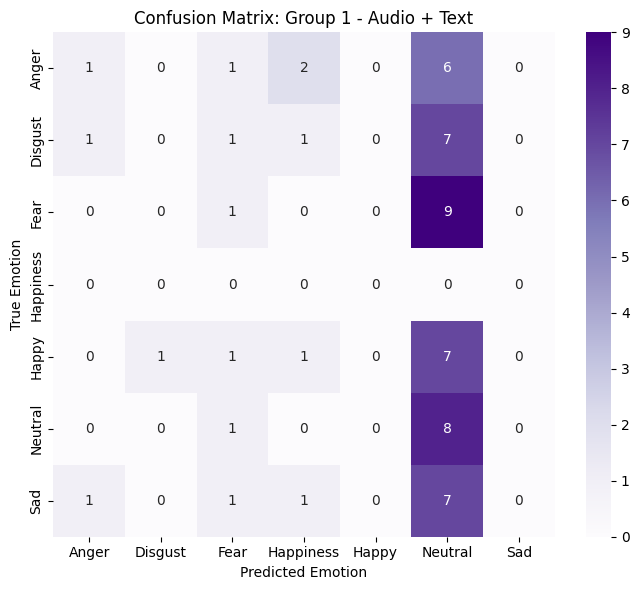


 Evaluation for Group 2 - Audio + Text
 Accuracy: 0.6333

 Classification Report:
              precision    recall  f1-score   support

       Anger       0.00      0.00      0.00         0
     Disgust       0.00      0.00      0.00         0
        Fear       0.00      0.00      0.00         0
   Happiness       0.00      0.00      0.00         0
     Neutral       1.00      0.63      0.78        60
     Sadness       0.00      0.00      0.00         0

    accuracy                           0.63        60
   macro avg       0.17      0.11      0.13        60
weighted avg       1.00      0.63      0.78        60



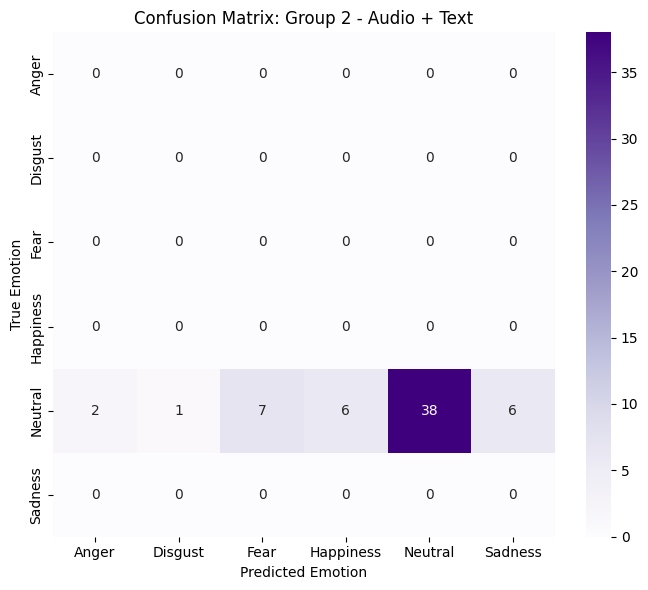


 Evaluation for Group 3 - Audio + Text
 Accuracy: 0.1667

 Classification Report:
              precision    recall  f1-score   support

       Anger       0.29      0.20      0.24        10
     Disgust       0.00      0.00      0.00        10
        Fear       0.29      0.20      0.24        10
   Happiness       0.00      0.00      0.00         0
       Happy       0.00      0.00      0.00        10
     Neutral       0.18      0.60      0.28        10
         Sad       0.00      0.00      0.00        10
     Sadness       0.00      0.00      0.00         0

    accuracy                           0.17        60
   macro avg       0.09      0.12      0.09        60
weighted avg       0.13      0.17      0.12        60



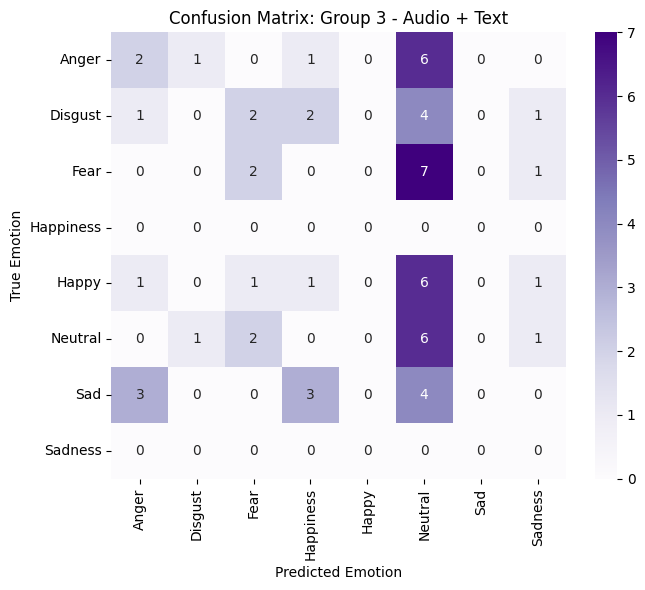

In [36]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_text_group(df, group_name, modality):
    print(f"\n Evaluation for {group_name} - {modality}")

    # Get true and predicted labels
    y_true = df["tone"]
    y_pred = df["predicted_emotion"]

    # Get sorted unique labels
    unique_labels = sorted(list(set(y_true) | set(y_pred)))

    # Accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f" Accuracy: {acc:.4f}")

    # Classification report
    print("\n Classification Report:")
    print(classification_report(y_true, y_pred, target_names=unique_labels, zero_division=0))

    # Confusion matrix heatmap
    cm = confusion_matrix(y_true, y_pred, labels=unique_labels)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Purples",
                xticklabels=unique_labels, yticklabels=unique_labels)
    plt.title(f"Confusion Matrix: {group_name} - {modality}")
    plt.xlabel("Predicted Emotion")
    plt.ylabel("True Emotion")
    plt.tight_layout()
    plt.show()

# Run evaluations
# Run evaluations
evaluate_text_group(group1_pred_text, "Group 1", "Audio + Text")
evaluate_text_group(group2_pred_text, "Group 2", "Audio + Text")
evaluate_text_group(group3_pred_text, "Group 3", "Audio + Text")